In [1]:
import gc
import logging
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# print list available devices
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
df_test = pd.read_csv('BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv')
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format='mixed')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161788 entries, 0 to 161787
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Timestamp                              161788 non-null  datetime64[ns]
 1   PT N2 'C' Speed                        161788 non-null  float64       
 2   Gear High Speed Drive End X Vibr       161788 non-null  float64       
 3   Gear High Speed Drive End Y Vibr       161788 non-null  float64       
 4   Gear High Speed Non-Drive End X Vibr   161788 non-null  float64       
 5   Gear High Speed Non-Drive End Y Vibr   161788 non-null  float64       
 6   Gear LS Shaft Axial Displ 1            161788 non-null  float64       
 7   Gear LS Shaft Axial Displ 2            161788 non-null  float64       
 8   Gear Low Speed Drive End X Vibr        161788 non-null  float64       
 9   Gear Low Speed DriveEnd Y Vibr         161788 no

In [3]:
# Helper function for selecting data easier
def data_selector(data, features, time_range_low=None, time_range_high=None):
    if time_range_low != None and time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low) & (data['Timestamp'] <= time_range_high)]
    elif time_range_low != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low)]
    elif time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] <= time_range_low)]
    data_selected = data_selected_time[features]
    return data_selected

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

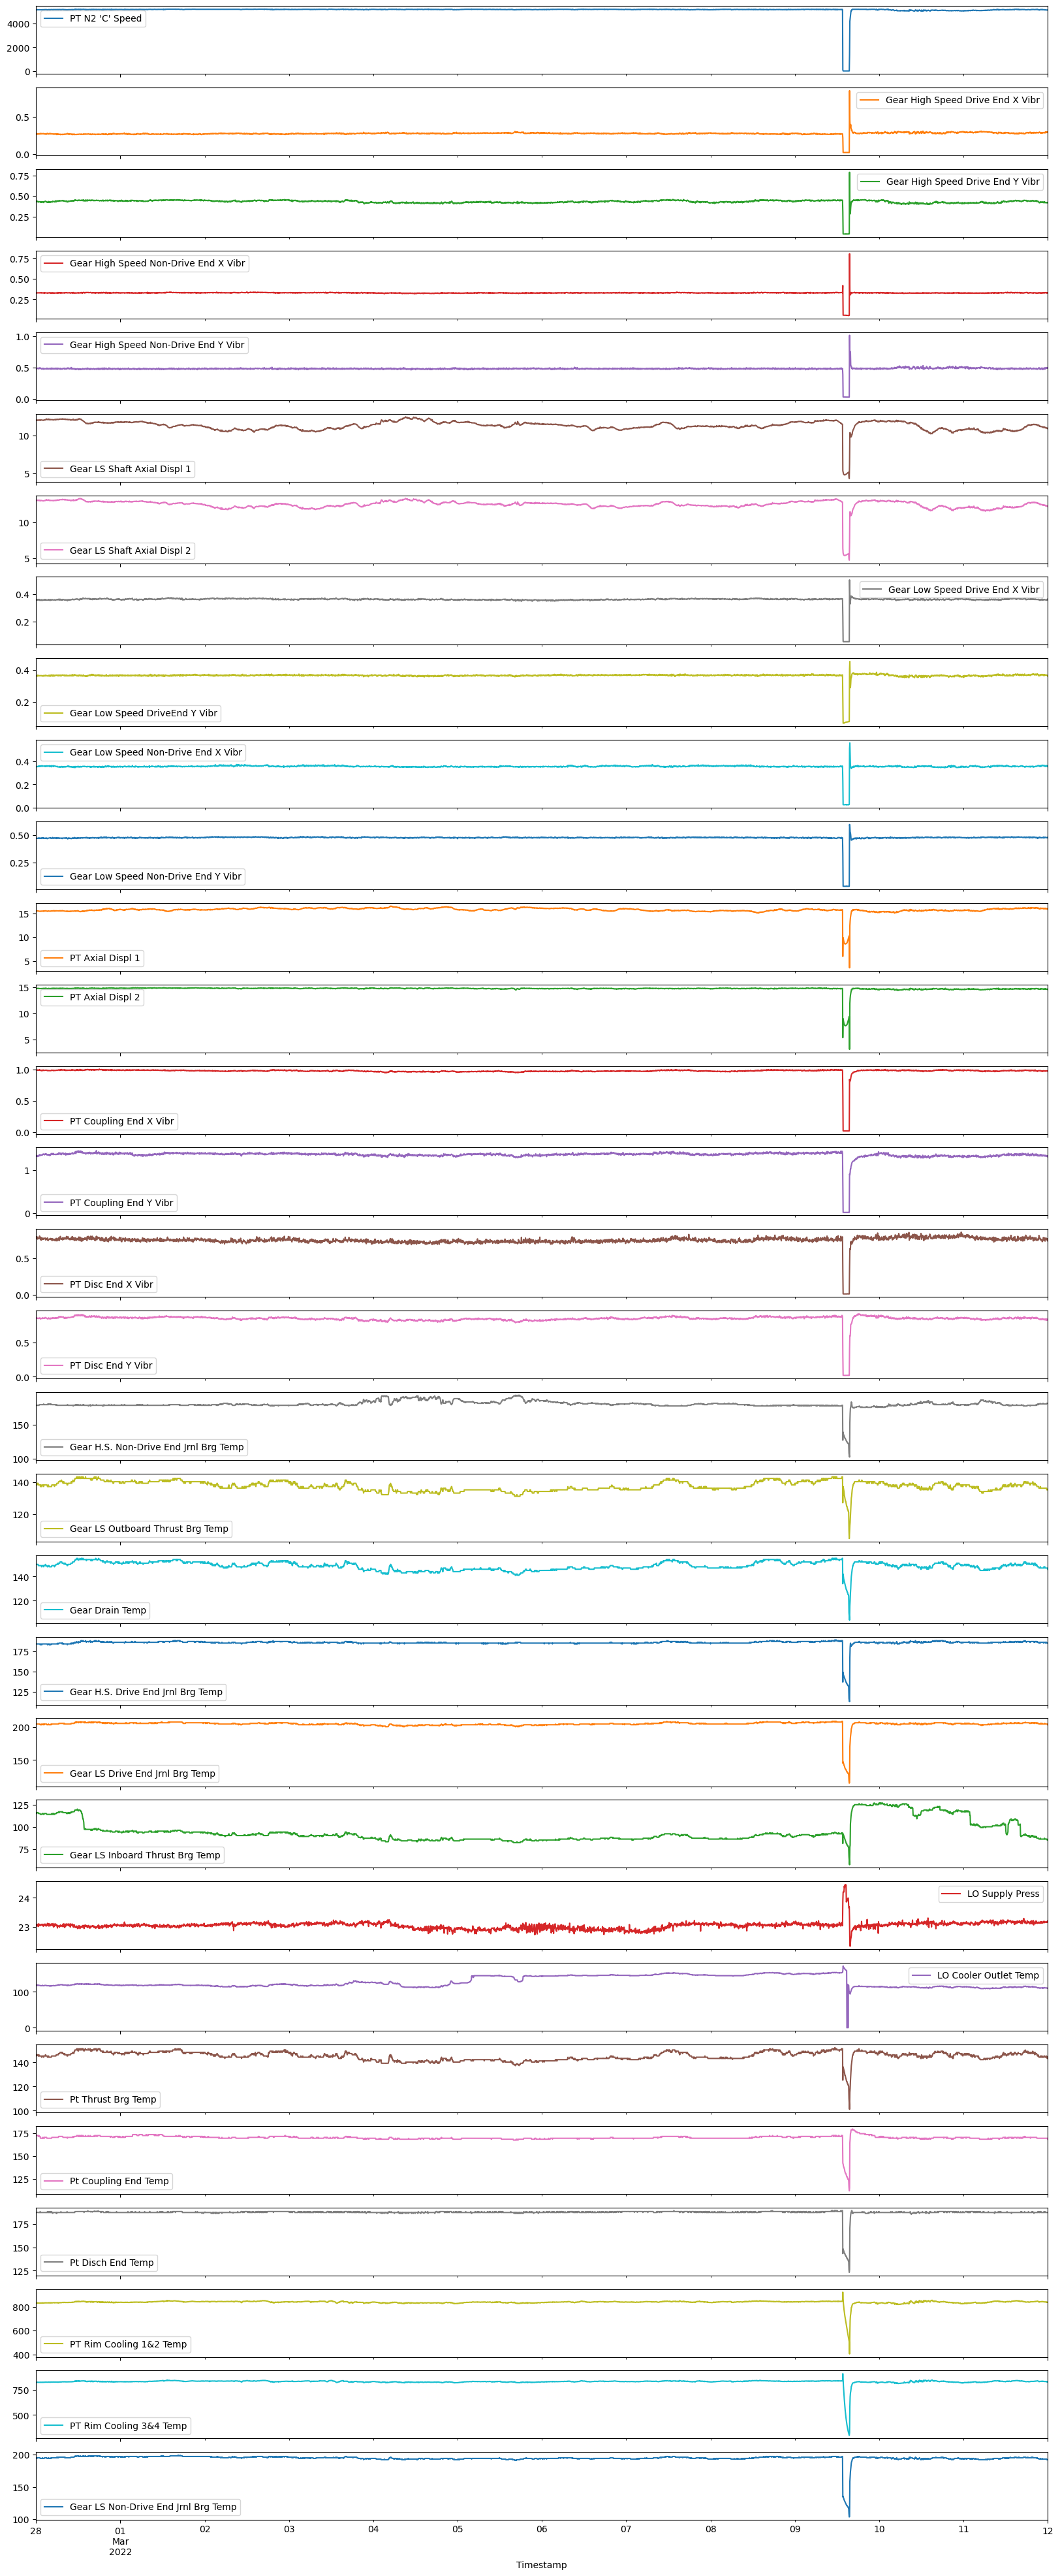

In [4]:
data_test = data_selector(df_test, df_test.columns, time_range_low='2022-02-28 00:00:00', time_range_high='2022-03-12 00:00:00')
data_test.plot(x='Timestamp',subplots=True, figsize=(20, 50))

In [5]:
features = data_test.drop('Timestamp', axis=1).columns.to_list()

# standardize the data
from sklearn.preprocessing import StandardScaler
# create scaler for each feature
scalers = {}
for feature in features:
    scaler = StandardScaler()
    scaler.fit(data_test[feature].values.reshape(-1, 1))
    scalers[feature] = scaler
    data_test[feature] = scaler.transform(data_test[feature].values.reshape(-1, 1))

In [6]:
# Create a custom logger
logger = logging.getLogger(__name__)

# Set level of logger
logger.setLevel(logging.DEBUG)

# Create handlers
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler('tensorflow.log')
c_handler.setLevel(logging.WARNING)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add it to handlers
c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)

# Set the logger as the default logger
tf.get_logger().setLevel('INFO')
tf.get_logger().addHandler(f_handler)

In [7]:
# load models for each feature
models = {}

# debugging mode
tf.debugging.set_log_device_placement(True)
for feature in features:
    model = tf.keras.models.load_model('models_mlp/{}.h5'.format(feature))
    models[feature] = model

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job

In [8]:
predictions = []
# predict
data_test.drop('Timestamp', axis=1, inplace=True)

In [9]:
# enumerate through each feature
with tf.device('/GPU:0'):
    for i, feature in enumerate(features):
        # predict using the model
        predictions.append(models[feature].predict(data_test.drop(feature, axis=1).values))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapData

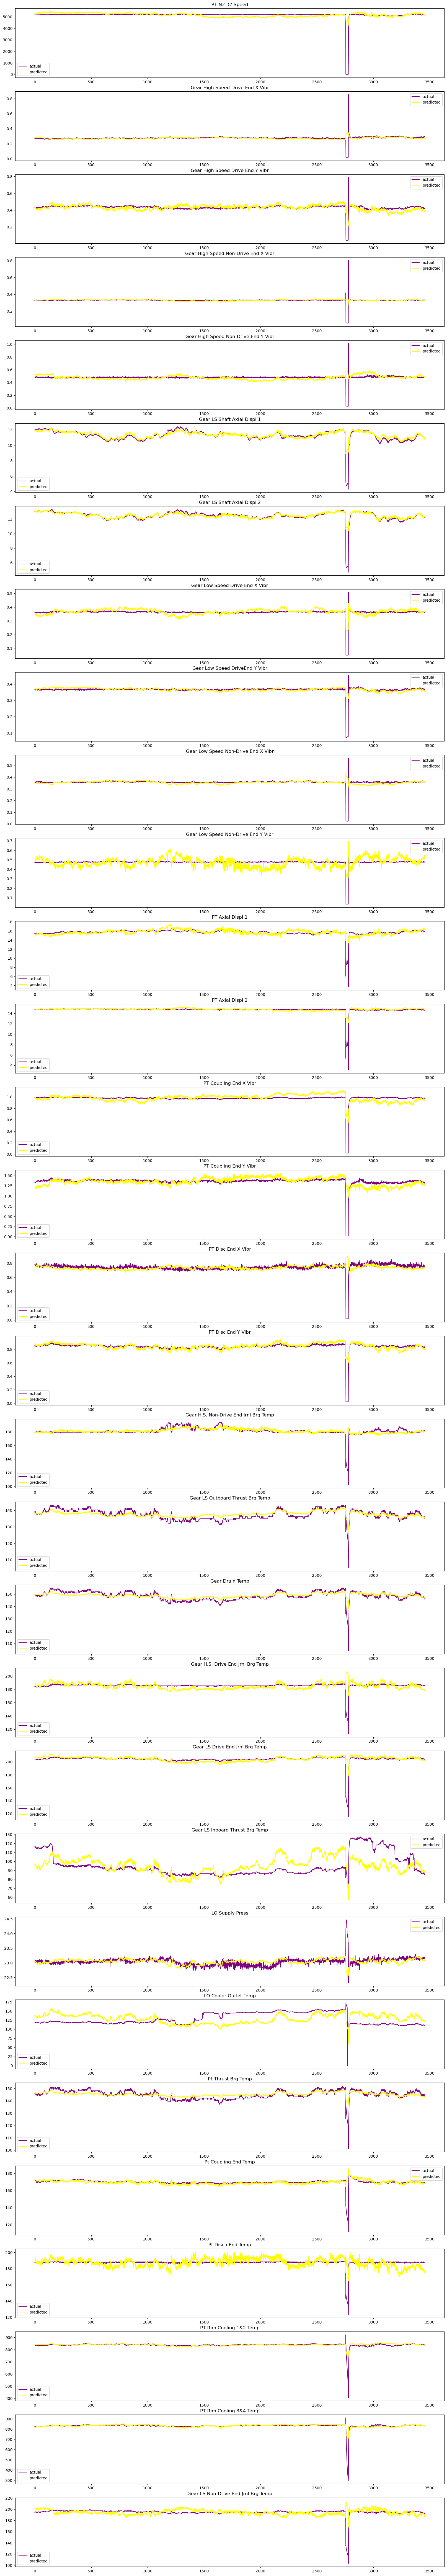

In [10]:
# inverse transform the predictions and data test
for i, feature in enumerate(features):
    predictions[i] = scalers[feature].inverse_transform(predictions[i])
    data_test[feature] = scalers[feature].inverse_transform(data_test[feature].values.reshape(-1, 1))

# plot the predictions
fig, axs = plt.subplots(len(features), figsize=(20, 120))
for i, feature in enumerate(features):
    axs[i].plot(data_test[feature].values, label='actual', color='purple')
    axs[i].plot(predictions[i], label='predicted', color='yellow')
    axs[i].set_title(feature)
    axs[i].legend()
